In [2]:
import matplotlib
import uproot, uproot3
import numpy
import numba
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array

from Lumi import *
from TDR_Style import *
from Ratio_Plot import *

Welcome to JupyROOT 6.24/06


In [3]:
@numba.njit
def sgn(num):
    if (num >= 0):
        return 1
    else:
        return -1

### 1. Template Distribution

In [8]:
def AddHist_FTdist(file, branch, hist_pre1, hist_pre2, isData, xsec):
    
    if isData:
        print('is Data')
        init_branches = ['is_lepton_tight','jet_pt','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all',
                                                       'HLT_IsoMu24','HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt',
                                                      'HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']
        if not (branch in init_branches):
            init_branches.append(branch)
        branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

    else:
        print('is MC')
        init_branches = ['is_lepton_tight','jet_pt','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all','lepton_gen_matching','gen_weight',
                                                       'HLT_IsoMu24','HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt',
                                                      'HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30']
        if not (branch in init_branches):
            init_branches.append(branch)
        branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]

        weight_lowpt = (1000*xsec*0.00780) / true_events
        weight_highpt = (1000*xsec*0.21675) / true_events
        lepton_gen_cut1 = branches.loc[:,'lepton_gen_matching'] == 1
        lepton_gen_cut2 = branches.loc[:,'lepton_gen_matching'] == 15
        
    HLT_cut1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL'] == True
    HLT_cut2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL'] == True
    
    met_cut = branches.loc[:,'met'] < 2000
    mt_cut = branches.loc[:,'mt'] < 20
    lepton_cut = abs(branches.loc[:,'lepton_pdgid']) == 13
 #   pf_cut = branches.loc[:,'lepton_pfRelIso04_all'] < 0.4
    pf_cut = branches.loc[:,'is_lepton_tight'] == 1
    pt_edge = branches.loc[:,'lepton_pt'] < 20
    jet_pt = branches.loc[:,'jet_pt'] > 35
    
    if isData:
        arrays_0_20 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & jet_pt,:] 
        arrays_20_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & jet_pt,:] 
        for i in trange(0, len(arrays_0_20[branch]), desc=f'fill pt<20 part for {file}'):
            hist_pre1.Fill(float(arrays_0_20[branch].values[i]))
        for i in trange(0, len(arrays_20_Inf[branch]), desc=f'fill pt>20 part for {file}'):
            hist_pre2.Fill(float(arrays_20_Inf[branch].values[i]))
    
    else:
        if ('TTbar' in file) or ('QCD' in file):
            print ("QCD process\n")
            arrays_0_20 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & jet_pt,:] 
            arrays_20_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & jet_pt,:] 
        else:
            arrays_0_20 = branches.loc[HLT_cut1 & lepton_cut & pf_cut & pt_edge & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:] 
            arrays_20_Inf = branches.loc[HLT_cut2 & lepton_cut & pf_cut & ~pt_edge & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:] 
        for i in trange(0, len(arrays_0_20[branch]), desc=f'fill pt<20 part for {file}'):
            hist_pre1.Fill(float(arrays_0_20[branch].values[i]), weight_lowpt*sgn(arrays_0_20['gen_weight'].values[i]))
        for i in trange(0, len(arrays_20_Inf[branch]), desc=f'fill pt>20 part for {file}'):
            hist_pre2.Fill(float(arrays_20_Inf[branch].values[i]), weight_highpt*sgn(arrays_20_Inf['gen_weight'].values[i]))
        
    print("DONE")
    return True

### MET dist

In [9]:
xbins = 20
xlow = 0
xup = 200
branch = 'met'

ptbins = [10, 13, 16, 20, 24, 28, 35, 45, 200]

hist_dist1_DATA = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_DATA = ROOT.TH1D("","",xbins, xlow, xup)

hist_dist1_DATA.Sumw2()
hist_dist2_DATA.Sumw2()

file_list = [
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016B.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016C.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016E.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016F.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016G.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016H.root'
]

for file in file_list:
    AddHist_FTdist(file, branch, hist_dist1_DATA, hist_dist2_DATA, 1, 1)

hist_dist1_WJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_WJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist1_ZJets = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_ZJets = ROOT.TH1D("","",xbins, xlow, xup)

hist_dist1_WJets.Sumw2()
hist_dist2_WJets.Sumw2()
hist_dist1_ZJets.Sumw2()
hist_dist2_ZJets.Sumw2()

file_WJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets2 = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'

AddHist_FTdist(file_WJets, branch, hist_dist1_WJets, hist_dist2_WJets, 0, 61526.7)
AddHist_FTdist(file_ZJets, branch, hist_dist1_ZJets, hist_dist2_ZJets, 0, 6077.22)
AddHist_FTdist(file_ZJets2, branch, hist_dist1_ZJets, hist_dist2_ZJets, 0, 18610)

hist_dist1_ttbar = ROOT.TH1D("","",xbins, xlow, xup)
hist_dist2_ttbar = ROOT.TH1D("","",xbins, xlow, xup)

hist_dist1_ttbar.Sumw2()
hist_dist2_ttbar.Sumw2()

# -- Muon channel
file_list_QCD = [
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-15to20_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-20to30_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-30to50_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-50to80_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-800to1000_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root",
    "/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-80to120_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root"
]

xsec_list_QCD = [
    1.078,
    21230,
    2799000,
    7055,
    2526000,
    619.3,
    1362000,
    59.24,
    376600,
    18.21,
    3.275,
    88930
]

for i in range(len(file_list_QCD)):
    AddHist_FTdist(file_list_QCD[i], branch, hist_dist1_ttbar, hist_dist2_ttbar, 0, xsec_list_QCD[i])

is Data


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016B.root: 100%|██████████| 99679/99679 [00:00<00:00, 212721.46it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016B.root: 100%|██████████| 485408/485408 [00:02<00:00, 206484.85it/s]


DONE
is Data


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016C.root: 100%|██████████| 10076/10076 [00:00<00:00, 133753.44it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016C.root: 100%|██████████| 32909/32909 [00:00<00:00, 173885.55it/s]


DONE
is Data


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016E.root: 100%|██████████| 13666/13666 [00:00<00:00, 152272.18it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016E.root: 100%|██████████| 65243/65243 [00:00<00:00, 179692.11it/s]


DONE
is Data


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016F.root: 100%|██████████| 5849/5849 [00:00<00:00, 120989.74it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016F.root: 100%|██████████| 26841/26841 [00:00<00:00, 172341.22it/s]


DONE
is Data


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016G.root: 100%|██████████| 10562/10562 [00:00<00:00, 221773.98it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016G.root: 100%|██████████| 38958/38958 [00:00<00:00, 222006.24it/s]


DONE
is Data


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016H.root: 100%|██████████| 10453/10453 [00:00<00:00, 222694.91it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016H.root: 100%|██████████| 39159/39159 [00:00<00:00, 215704.80it/s]


DONE
is MC


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 100134/100134 [00:01<00:00, 88528.75it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 286361/286361 [00:02<00:00, 111377.26it/s]


DONE
is MC


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 677666/677666 [00:06<00:00, 100108.39it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 937082/937082 [00:09<00:00, 99332.00it/s] 


DONE
is MC


fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 30274/30274 [00:00<00:00, 75888.94it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 24116/24116 [00:00<00:00, 94237.69it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 21140/21140 [00:00<00:00, 79502.32it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-1000toInf_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 35687/35687 [00:00<00:00, 89749.43it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 148690/148690 [00:01<00:00, 101338.34it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 177217/177217 [00:02<00:00, 87919.72it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-15to20_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 1260/1260 [00:00<00:00, 52847.70it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-15to20_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 23/23 [00:00<00:00, 31199.54it/s]

DONE
is MC


QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 183140/183140 [00:01<00:00, 97997.02it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 242429/242429 [00:02<00:00, 86101.85it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-20to30_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 92735/92735 [00:00<00:00, 95284.22it/s] 
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-20to30_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 2875/2875 [00:00<00:00, 105226.35it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 164318/164318 [00:01<00:00, 99726.31it/s] 
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 241246/241246 [00:02<00:00, 101945.49it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-30to50_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 398300/398300 [00:03<00:00, 111134.18it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-30to50_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 73042/73042 [00:00<00:00, 88950.11it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 51742/51742 [00:00<00:00, 115410.60it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 81850/81850 [00:00<00:00, 114672.12it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-50to80_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 313348/313348 [00:02<00:00, 106308.47it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-50to80_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 176891/176891 [00:01<00:00, 112956.82it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 36349/36349 [00:00<00:00, 88678.15it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-600to800_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 60423/60423 [00:00<00:00, 108385.38it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-800to1000_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 28540/28540 [00:00<00:00, 114628.87it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-800to1000_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 49525/49525 [00:00<00:00, 114472.73it/s]


DONE
is MC
QCD process



fill pt<20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-80to120_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 255103/255103 [00:02<00:00, 112331.79it/s]
fill pt>20 part for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_QCD/QCD_Pt-80to120_MuEnrichedPt5_TuneCP5_13TeV_pythia8_2016.root: 100%|██████████| 243809/243809 [00:02<00:00, 105547.56it/s]


DONE


35.86 fb^{-1} (13 TeV)


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


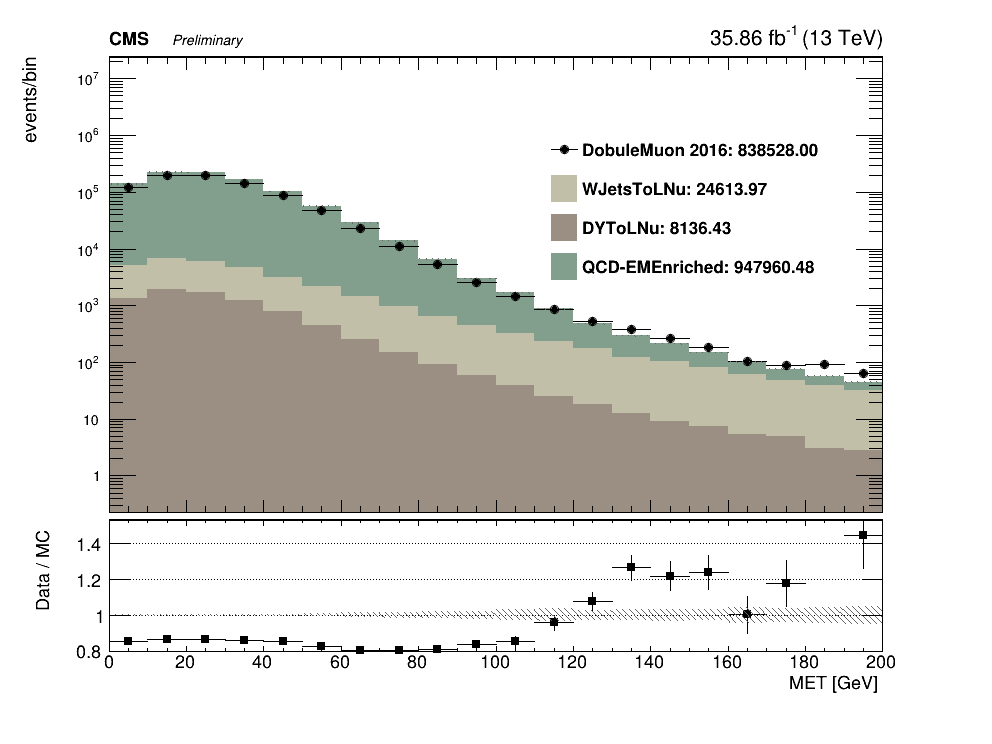

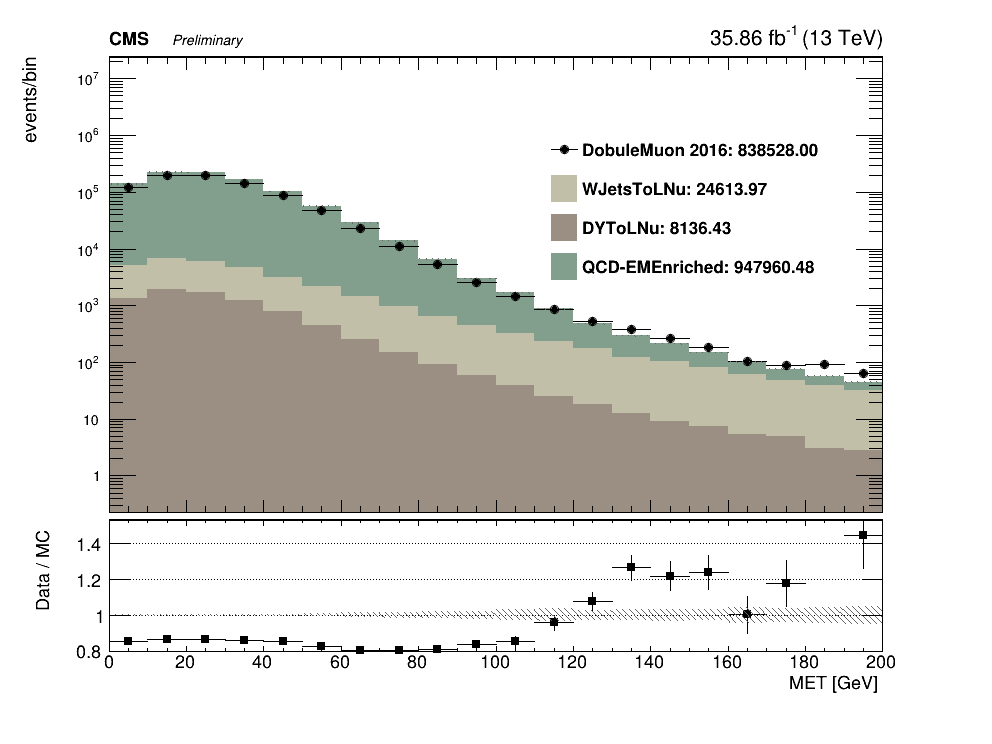

In [12]:
c1 = ROOT.TCanvas("","",1000,800)

def SetHistStyle_dist(hist, color, isData):
    if isData:
        hist.SetMarkerStyle(20)
        hist.SetMarkerColor(color)
    else:
        hist.SetFillColor(color)
        hist.SetFillStyle(4100)
        hist.SetLineColor(color)
        hist.SetLineStyle(0)
        hist.SetLineWidth(0)
    hist.SetYTitle('events/bin')
    hist.SetXTitle('MET [GeV]')
    # Adjust y-axis settings
    # hist.GetYaxis().SetNdivisions(105)
    hist.GetYaxis().SetTitleSize(25)
    hist.GetYaxis().SetTitleFont(43)
    hist.GetYaxis().SetTitleOffset(1.40)
    hist.GetYaxis().SetLabelFont(43)
    hist.GetYaxis().SetLabelSize(25)

    # Adjust x-axis settings
    hist.GetXaxis().SetTitleSize(25)
    hist.GetXaxis().SetTitleFont(43)
    hist.GetXaxis().SetTitleOffset(5.0)
    hist.GetXaxis().SetLabelFont(43)
    hist.GetXaxis().SetLabelSize(25)
    hist.SetStats(0)


SetHistStyle_dist(hist_dist1_WJets, 22, 0)
SetHistStyle_dist(hist_dist2_WJets, 22, 0)
SetHistStyle_dist(hist_dist1_ZJets, 27, 0)
SetHistStyle_dist(hist_dist2_ZJets, 27, 0)
SetHistStyle_dist(hist_dist1_ttbar, 32, 0)
SetHistStyle_dist(hist_dist2_ttbar, 32, 0)
SetHistStyle_dist(hist_dist1_DATA, 1, 1)
SetHistStyle_dist(hist_dist2_DATA, 1, 1)

hist_dist_WJets = hist_dist1_WJets.Clone()
hist_dist_WJets.Add(hist_dist2_WJets)
SetHistStyle_dist(hist_dist_WJets, 22, 0)
hist_dist_ZJets = hist_dist1_ZJets.Clone()
hist_dist_ZJets.Add(hist_dist2_ZJets)
SetHistStyle_dist(hist_dist_ZJets, 27, 0)
hist_dist_ttbar = hist_dist1_ttbar.Clone()
hist_dist_ttbar.Add(hist_dist2_ttbar)
SetHistStyle_dist(hist_dist_ttbar, 32, 0)

hs_dist = ROOT.THStack("",";M_{T,e} [GeV];events/bin")
hs_dist.Add(hist_dist_ZJets)
hs_dist.Add(hist_dist_WJets)
hs_dist.Add(hist_dist_ttbar)

MC_err = ROOT.TH1D("","",xbins,xlow,xup)
# MC_err = ROOT.TH1D("","",8,array('d',ptbins))
MC_err.Sumw2()
MC_err.Add(hist_dist1_WJets)
MC_err.Add(hist_dist2_WJets)
MC_err.Add(hist_dist1_ZJets)
MC_err.Add(hist_dist2_ZJets)
MC_err.Add(hist_dist1_ttbar)
MC_err.Add(hist_dist2_ttbar)
MC_err.SetFillColor(ROOT.kGray+2)
MC_err.SetFillStyle(3345)
MC_err.SetMarkerSize(0.)
MC_err.SetMarkerColor(ROOT.kGray+2)
MC_err.SetLineWidth(2)
MC_err.SetLineColor(0)
MC_err.SetStats(0)

hs_data = ROOT.TH1D("","",xbins,xlow,xup)
# hs_data = ROOT.TH1D("","",8,array('d',ptbins))
hs_data.Add(hist_dist1_DATA)
hs_data.Add(hist_dist2_DATA)
SetHistStyle_dist(hs_data, 1, 1)

legend = ROOT.TLegend(0.55, 0.45, 0.70, 0.75)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.035)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
# legend.AddEntry(hist_dist1_DATA,'Double Muon 2018')
legend.AddEntry(hist_dist1_DATA,f'DobuleMuon 2016: {format(hs_data.GetSumOfWeights(), ".2f")}')
legend.AddEntry(hist_dist1_WJets,f'WJetsToLNu: {format(hist_dist_WJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ZJets,f'DYToLNu: {format(hist_dist_ZJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ttbar,f'QCD-EMEnriched: {format(hist_dist_ttbar.GetSumOfWeights(), ".2f")}','F')

c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.015)  # joins upper and lower plot
# pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)  # joins upper and lower plot
pad2.SetBottomMargin(0.3)
pad2.SetGridy()
pad2.Draw()

# draw everything
pad1.cd()
# hs_data.GetYaxis().SetMaxDigits(3)
hs_dist.Draw("HIST")
hs_dist.SetMaximum(10000000)
hs_dist.SetMinimum(1)
# hs_dist.GetXaxis().SetRangeUser(10,60)
hs_dist.GetXaxis().SetLabelSize(0)
hs_data.Draw("ep SAME")
MC_err.Draw("e2 SAME")
legend.Draw("SAME")
ROOT.gPad.SetLogy()
ROOT.gPad.RedrawAxis()


# h1.GetXaxis().SetLabelSize(0)
pad2.cd()
h3 = createRatio(hs_data, MC_err)
h4 = createRatio(MC_err, MC_err)
h3.Draw("ep")
# h3.GetXaxis().SetRangeUser(10,60)
h4.Draw("e2 SAME")
ROOT.gPad.RedrawAxis()

CMS_lumi(pad1, 0, 0)
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.png')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.pdf')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.png')

## SF

In [9]:
bin_left = hist_dist1_WJets.FindBin(0)
bin_right = hist_dist1_WJets.FindBin(20)

WJets_yields = hist_dist1_WJets.Integral(bin_left,bin_right) + hist_dist2_WJets.Integral(bin_left,bin_right)
ZJets_yields = hist_dist1_ZJets.Integral(bin_left,bin_right) + hist_dist2_ZJets.Integral(bin_left,bin_right)
ttbar_yields = hist_dist1_ttbar.Integral(bin_left,bin_right) + hist_dist2_ttbar.Integral(bin_left,bin_right)
data_yields = hist_dist1_DATA.Integral(bin_left,bin_right) + hist_dist2_DATA.Integral(bin_left,bin_right)

print (hist_dist1_WJets.FindBin(0),hist_dist1_WJets.FindBin(20))
print (f"WJets yields in EWK CR: {WJets_yields}")
print (f"ZJets yields in EWK CR: {ZJets_yields}")
print (f"QCD yields in EWK CR: {ttbar_yields}")
print (f"data yields in EWK CR: {data_yields}")
print (f"SF = {data_yields} / {WJets_yields + ZJets_yields + ttbar_yields}  = {data_yields/(WJets_yields+ZJets_yields+ttbar_yields)}")
SF = data_yields/(WJets_yields+ZJets_yields+ttbar_yields)

1 3
WJets yields in EWK CR: 13018.547909254921
ZJets yields in EWK CR: 4963.663594576219
QCD yields in EWK CR: 575500.6361998776
data yields in EWK CR: 511077.0
SF = 511077.0 / 593482.8477037087  = 0.861148729028056


35.86 fb^{-1} (13 TeV)


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


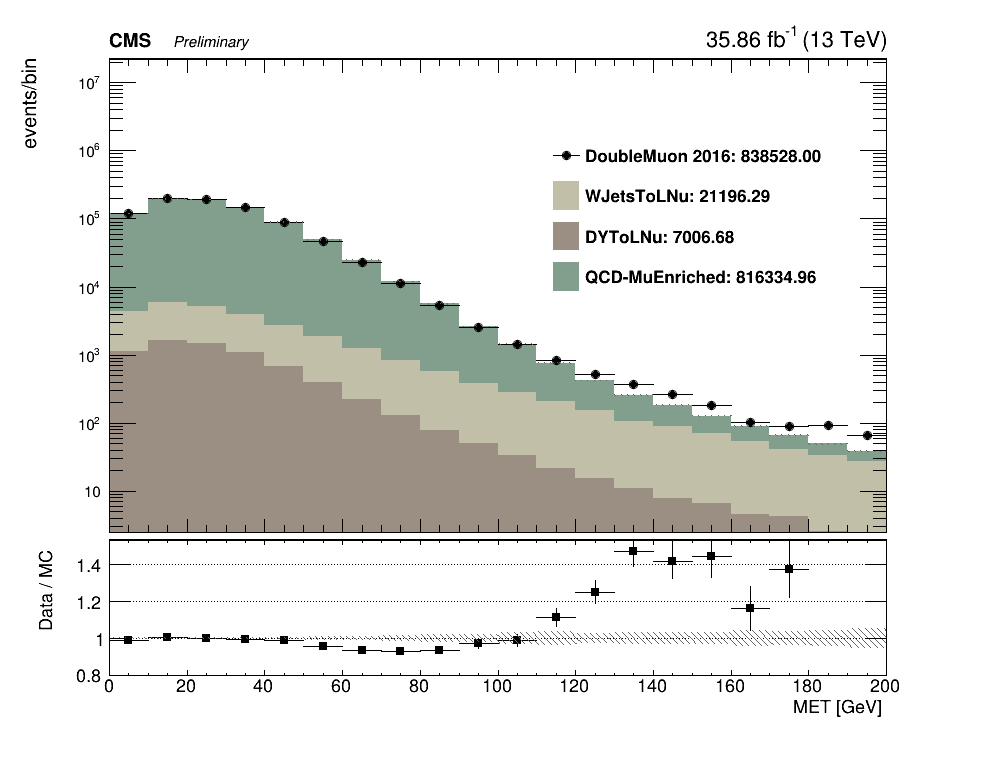

In [10]:
c1 = ROOT.TCanvas("","",1000,800)

SetHistStyle_dist(hist_dist1_WJets, 22, 0)
SetHistStyle_dist(hist_dist2_WJets, 22, 0)
SetHistStyle_dist(hist_dist1_ZJets, 27, 0)
SetHistStyle_dist(hist_dist2_ZJets, 27, 0)
SetHistStyle_dist(hist_dist1_ttbar, 32, 0)
SetHistStyle_dist(hist_dist2_ttbar, 32, 0)
SetHistStyle_dist(hist_dist1_DATA, 1, 1)
SetHistStyle_dist(hist_dist2_DATA, 1, 1)

hist_dist_WJets = hist_dist1_WJets.Clone()
hist_dist_WJets.Add(hist_dist2_WJets)
SetHistStyle_dist(hist_dist_WJets, 22, 0)
hist_dist_ZJets = hist_dist1_ZJets.Clone()
hist_dist_ZJets.Add(hist_dist2_ZJets)
SetHistStyle_dist(hist_dist_ZJets, 27, 0)
hist_dist_ttbar = hist_dist1_ttbar.Clone()
hist_dist_ttbar.Add(hist_dist2_ttbar)
SetHistStyle_dist(hist_dist_ttbar, 32, 0)


hist_dist_ZJets.Scale(SF)
hist_dist_WJets.Scale(SF)
hist_dist_ttbar.Scale(SF)

hs_dist = ROOT.THStack("",";M_{T,e} [GeV];events/bin")
hs_dist.Add(hist_dist_ZJets)
hs_dist.Add(hist_dist_WJets)
hs_dist.Add(hist_dist_ttbar)



MC_err = ROOT.TH1D("","",xbins,xlow,xup)
# MC_err = ROOT.TH1D("","",8,array('d',ptbins))
MC_err.Sumw2()
MC_err.Add(hist_dist1_WJets)
MC_err.Add(hist_dist2_WJets)
MC_err.Add(hist_dist1_ZJets)
MC_err.Add(hist_dist2_ZJets)
MC_err.Add(hist_dist1_ttbar)
MC_err.Add(hist_dist2_ttbar)
MC_err.SetFillColor(ROOT.kGray+2)
MC_err.SetFillStyle(3345)
MC_err.SetMarkerSize(0.)
MC_err.SetMarkerColor(ROOT.kGray+2)
MC_err.SetLineWidth(2)
MC_err.SetLineColor(0)
MC_err.SetStats(0)

MC_err.Scale(SF)


hs_data = ROOT.TH1D("","",xbins,xlow,xup)
# hs_data = ROOT.TH1D("","",8,array('d',ptbins))
hs_data.Add(hist_dist1_DATA)
hs_data.Add(hist_dist2_DATA)
SetHistStyle_dist(hs_data, 1, 1)

legend = ROOT.TLegend(0.55, 0.45, 0.70, 0.75)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.035)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
# legend.AddEntry(hist_dist1_DATA,'Double Muon 2018')
legend.AddEntry(hist_dist1_DATA,f'DoubleMuon 2016: {format(hs_data.GetSumOfWeights(), ".2f")}')
legend.AddEntry(hist_dist1_WJets,f'WJetsToLNu: {format(hist_dist_WJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ZJets,f'DYToLNu: {format(hist_dist_ZJets.GetSumOfWeights(), ".2f")}','F')
legend.AddEntry(hist_dist1_ttbar,f'QCD-MuEnriched: {format(hist_dist_ttbar.GetSumOfWeights(), ".2f")}','F')

c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.015)  # joins upper and lower plot
# pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)  # joins upper and lower plot
pad2.SetBottomMargin(0.3)
pad2.SetGridy()
pad2.Draw()

# draw everything
pad1.cd()
# hs_data.GetYaxis().SetMaxDigits(3)
hs_dist.Draw("HIST")
hs_dist.SetMaximum(10000000)
hs_dist.SetMinimum(10)
# hs_dist.GetXaxis().SetRangeUser(10,60)
hs_dist.GetXaxis().SetLabelSize(0)
hs_data.Draw("ep SAME")
MC_err.Draw("e2 SAME")
legend.Draw("SAME")
ROOT.gPad.SetLogy()
ROOT.gPad.RedrawAxis()


# h1.GetXaxis().SetLabelSize(0)
pad2.cd()
h3 = createRatio(hs_data, MC_err)
h4 = createRatio(MC_err, MC_err)
h3.Draw("ep")
# h3.GetXaxis().SetRangeUser(10,60)
h4.Draw("e2 SAME")
ROOT.gPad.RedrawAxis()

CMS_lumi(pad1, 0, 0)
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/eta_TightElectron_dist_MR_2017_new.png')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.pdf')
#c1.SaveAs('Fake_Lepton/2017/MET_FakeElectron_dist_MR_2017_new.png')

0.9353511930232628
0.010716670842543354
0.930787275739107
0.014418886736063978


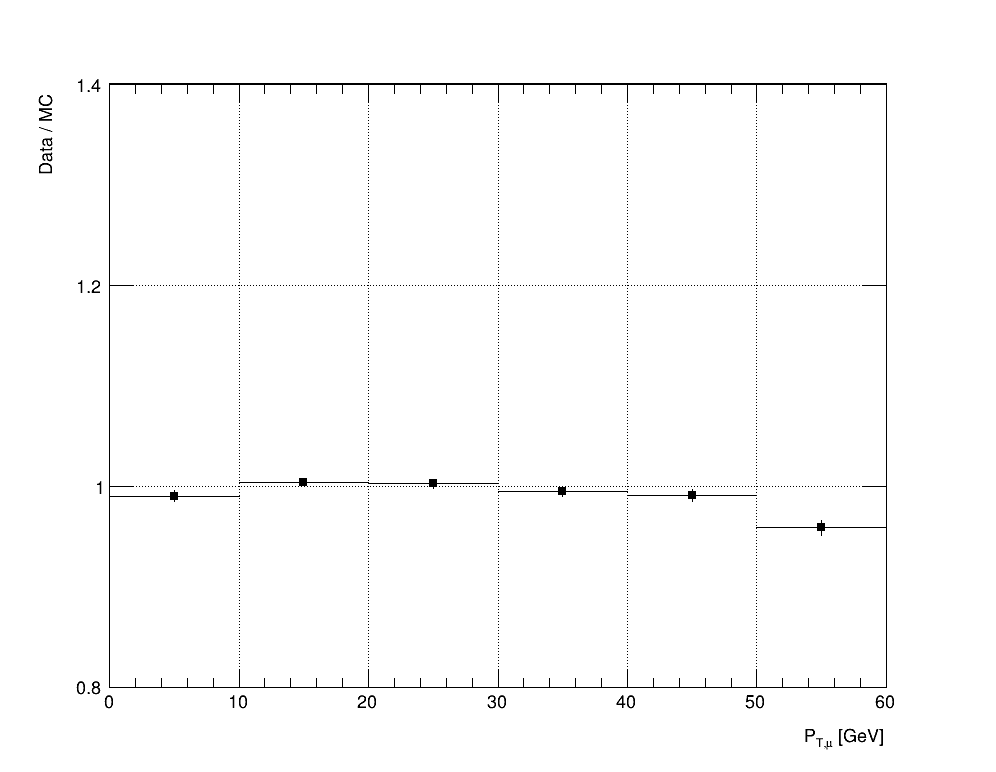

In [11]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()


h3.Draw('ep')
h3.SetXTitle('P_{T,#mu} [GeV]')
h3.GetXaxis().SetTitleOffset(1.6)
h3.GetXaxis().SetRangeUser(0,60)
h3.SetMaximum(1.4)
#h3.SetMinimum(0)
ROOT.gPad.SetGridy()
ROOT.gPad.SetGridx()

print(h3.GetBinContent(7))
print(h3.GetBinError(7))
print(h3.GetBinContent(8))
print(h3.GetBinError(8))

## Muon Fake Rate

In [12]:
def AddHist_FR_Ele(file, h_nume_e, h_deno_e, isAdd, isData, lumi_Ele12, lumi_Ele23, xsec):
    
    if isData:
        print('is Data')
        branches = uproot.open(file+':Events').arrays(['jet_pt','is_lepton_tight','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all',
                                                       'HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30',
                                                       'HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt'], library='pd')
    else:
        print('is MC')
        branches = uproot.open(file+':Events').arrays(['jet_pt','is_lepton_tight','mt','met','lepton_pt','lepton_eta','lepton_pdgid','lepton_pfRelIso04_all',
                                                       'lepton_gen_matching','HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30','HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30',
                                                       'HLT_Mu8_TrkIsoVVL','HLT_Mu17_TrkIsoVVL','hlt','gen_weight'], library='pd')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        weight_lowpt = (1000*lumi_Mu8*xsec*isAdd) / true_events
        weight_highpt = (1000*lumi_Mu17*xsec*isAdd) / true_events
        lepton_gen_cut1 = branches.loc[:,'lepton_gen_matching'] == 1
        lepton_gen_cut2 = branches.loc[:,'lepton_gen_matching'] == 15
        
    HLT_cut1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL'] == True
    HLT_cut2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL'] == True
    met_cut = branches.loc[:,'met'] < 20
    mt_cut = branches.loc[:,'mt'] < 20
    Muon_cut = abs(branches.loc[:,'lepton_pdgid']) == 13
    pf_cut = branches.loc[:,'lepton_pfRelIso04_all'] < 0.15
    pt_edge = branches.loc[:,'lepton_pt'] < 20
    jet_pt = branches.loc[:,'jet_pt'] > 35

    
    overflow_Y = h_deno_m.GetYaxis().GetBinUpEdge(h_deno_m.GetNbinsY())
    center_upper_Y = h_deno_m.GetYaxis().GetBinCenter(h_deno_m.GetNbinsY())
    
    if isData:
        deno_m_lowpt = branches.loc[HLT_cut1 & pt_edge & Muon_cut & met_cut & mt_cut & jet_pt,:]
        deno_m_highpt = branches.loc[HLT_cut2 & ~pt_edge & Muon_cut & met_cut & mt_cut & jet_pt,:]
        
        
        for i in trange(0, len(deno_m_lowpt['lepton_pt']), desc=f'fill pt < 20 GeV for {file}'):
            if float(deno_m_lowpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), float(deno_m_lowpt['lepton_pt'].values[i]))
                if deno_m_lowpt['lepton_pfRelIso04_all'].values[i] < 0.15:
                    h_nume_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), float(deno_m_lowpt['lepton_pt'].values[i]))
            else:
                h_deno_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), center_upper_Y)
                if deno_m_lowpt['lepton_pfRelIso04_all'].values[i] < 0.15:
                    h_nume_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), center_upper_Y)
                
        for i in trange(0, len(deno_m_highpt['lepton_pt']), desc=f'fill pt > 20 GeV for {file}'):
            if float(deno_m_highpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), float(deno_m_highpt['lepton_pt'].values[i]))
                if deno_m_highpt['lepton_pfRelIso04_all'].values[i] < 0.15 :
                    h_nume_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), float(deno_m_highpt['lepton_pt'].values[i]))
            else:
                h_deno_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), center_upper_Y)
                if deno_m_highpt['lepton_pfRelIso04_all'].values[i] < 0.15:
                    h_nume_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), center_upper_Y)
                    
                
    else:
        deno_m_lowpt = branches.loc[HLT_cut1 & pt_edge & Muon_cut & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:].copy()
        deno_m_highpt = branches.loc[HLT_cut2 & ~pt_edge & Muon_cut & met_cut & mt_cut & (lepton_gen_cut1 | lepton_gen_cut2) & jet_pt,:].copy()
        
        # Add SF
        deno_m_highpt.loc[:,'SF'] = 1
        deno_m_highpt.loc[(deno_m_highpt['lepton_pt'] >= 35) & (deno_m_highpt['lepton_pt'] < 45), 'SF'] = 1
        deno_m_highpt.loc[deno_m_highpt['lepton_pt'] >= 45 , 'SF'] = 1
        
        
        for i in trange(0, len(deno_m_lowpt['lepton_pt']), desc=f'fill pt < 20 GeV for {file}'):
            if float(deno_m_lowpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), float(deno_m_lowpt['lepton_pt'].values[i]), weight_lowpt*sgn(deno_m_lowpt['gen_weight'].values[i]))
                if deno_m_lowpt['lepton_pfRelIso04_all'].values[i] < 0.15:                   
                    h_nume_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), float(deno_m_lowpt['lepton_pt'].values[i]), weight_lowpt*sgn(deno_m_lowpt['gen_weight'].values[i]))
            else:
                h_deno_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), center_upper_Y, weight_lowpt*sgn(deno_m_lowpt['gen_weight'].values[i]))
                if deno_m_lowpt['lepton_pfRelIso04_all'].values[i] < 0.15:
                    h_nume_m.Fill(abs(float(deno_m_lowpt['lepton_eta'].values[i])), center_upper_Y, weight_lowpt*sgn(deno_m_lowpt['gen_weight'].values[i]))
                
        for i in trange(0, len(deno_m_highpt['lepton_pt']), desc=f'fill pt > 20 GeV for {file}'):
            if float(deno_m_highpt['lepton_pt'].values[i]) < overflow_Y:
                h_deno_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), float(deno_m_highpt['lepton_pt'].values[i]), deno_m_highpt['SF'].values[i]*weight_highpt*sgn(deno_m_highpt['gen_weight'].values[i]))
                if deno_m_highpt['lepton_pfRelIso04_all'].values[i] < 0.15:
                    h_nume_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), float(deno_m_highpt['lepton_pt'].values[i]), deno_m_highpt['SF'].values[i]*weight_highpt*sgn(deno_m_highpt['gen_weight'].values[i]))
            else:
                h_deno_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), center_upper_Y, deno_m_highpt['SF'].values[i]*weight_highpt*sgn(deno_m_highpt['gen_weight'].values[i]))
                if deno_m_highpt['lepton_pfRelIso04_all'].values[i] < 0.15:
                    h_nume_m.Fill(abs(float(deno_m_highpt['lepton_eta'].values[i])), center_upper_Y, deno_m_highpt['SF'].values[i]*weight_highpt*sgn(deno_m_highpt['gen_weight'].values[i]))


    deno_counts = 0
    for i in range(h_deno_m.GetNbinsX()):
        for j in range(h_deno_m.GetNbinsY()):
            deno_counts += h_deno_m.GetBinContent(i+1,j+1) 

    nume_counts = 0
    for i in range(h_nume_m.GetNbinsX()):
        for j in range(h_nume_m.GetNbinsY()):
            nume_counts += h_nume_m.GetBinContent(i+1,j+1) 

    print (f"normalized deno :{deno_counts}")
    print (f"normalized nume :{nume_counts}")

Data processing

In [13]:
ybins = [10, 13, 16, 20, 24, 28, 35, 45, 60]
xbins = [.0, 0.5, 1.0, 1.5, 2.0, 2.5]

from array import array
h_deno_m = ROOT.TH2D("","", 5, array('d',xbins), 8, array('d',ybins))
h_deno_m.StatOverflows(1)
h_deno_m.Sumw2()
h_nume_m = ROOT.TH2D("","", 5, array('d',xbins), 8, array('d',ybins))
h_nume_m.StatOverflows(1)
h_nume_m.Sumw2()



file_list_M = [
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016B.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016C.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016E.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016F.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016G.root',
    '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016H.root'
]
for file_DATA in file_list_M:
    AddHist_FR_Ele(file_DATA, h_nume_m, h_deno_m, 1, 1, 0, 0, 0)

is Data


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016B.root: 100%|██████████| 42112/42112 [00:01<00:00, 32574.82it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016B.root: 100%|██████████| 183496/183496 [00:03<00:00, 49764.40it/s]


normalized deno :225338.0
normalized nume :73949.0
is Data


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016C.root: 100%|██████████| 4098/4098 [00:00<00:00, 49271.91it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016C.root: 100%|██████████| 11850/11850 [00:00<00:00, 49888.99it/s]


normalized deno :241263.0
normalized nume :79368.0
is Data


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016E.root: 100%|██████████| 5425/5425 [00:00<00:00, 49001.73it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016E.root: 100%|██████████| 23000/23000 [00:00<00:00, 49479.35it/s]


normalized deno :269651.0
normalized nume :89140.0
is Data


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016F.root: 100%|██████████| 2208/2208 [00:00<00:00, 27629.26it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016F.root: 100%|██████████| 9212/9212 [00:00<00:00, 31986.76it/s]


normalized deno :281059.0
normalized nume :93214.0
is Data


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016G.root: 100%|██████████| 4018/4018 [00:00<00:00, 33389.96it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016G.root: 100%|██████████| 13637/13637 [00:00<00:00, 37976.11it/s]


normalized deno :298691.0
normalized nume :99405.0
is Data


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016H.root: 100%|██████████| 3949/3949 [00:00<00:00, 49941.98it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/DoubleMuon_Run2016H.root: 100%|██████████| 13517/13517 [00:00<00:00, 49472.03it/s]


normalized deno :316136.0
normalized nume :105379.0


MC processing

In [14]:
file_WJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'
file_ZJets2 = '/eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root'

xsec_WJets = 61526.7  
xsec_ZJets = 6077.22 
xsec_ZJets2 = 18610

lumi_Mu8 = 0.00780 # HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30 2018 lumi
lumi_Mu17 = 0.21675 # HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30 2018 lumi

AddHist_FR_Ele(file_WJets, h_nume_m, h_deno_m, -1, 0, lumi_Mu8, lumi_Mu17, xsec_WJets)
AddHist_FR_Ele(file_ZJets, h_nume_m, h_deno_m, -1, 0, lumi_Mu8, lumi_Mu17, xsec_ZJets)
AddHist_FR_Ele(file_ZJets2, h_nume_m, h_deno_m, -1, 0, lumi_Mu8, lumi_Mu17, xsec_ZJets2)
print (lumi_Mu8, lumi_Mu17, xsec_WJets)
print (lumi_Mu8, lumi_Mu17, xsec_ZJets)
print (lumi_Mu8, lumi_Mu17, xsec_ZJets2)

is MC


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 22667/22667 [00:00<00:00, 31748.24it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 100836/100836 [00:04<00:00, 20885.03it/s]


normalized deno :307451.81618857046
normalized nume :97135.77723269569
is MC


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 154336/154336 [00:06<00:00, 25006.15it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 354278/354278 [00:17<00:00, 19827.76it/s]


normalized deno :305044.9384787049
normalized nume :94874.77047616686
is MC


fill pt < 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 14234/14234 [00:00<00:00, 31793.24it/s]
fill pt > 20 GeV for /eos/home-j/jiwoong/WZG_DB/2016/merged_FakeLepton_FR/merged_FakeLepFR_ZW/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8_2016.root: 100%|██████████| 11683/11683 [00:00<00:00, 20302.94it/s]


normalized deno :304214.52093613736
normalized nume :94112.56733194645
0.0078 0.21675 61526.7
0.0078 0.21675 6077.22
0.0078 0.21675 18610


35.86 fb^{-1} (13 TeV)


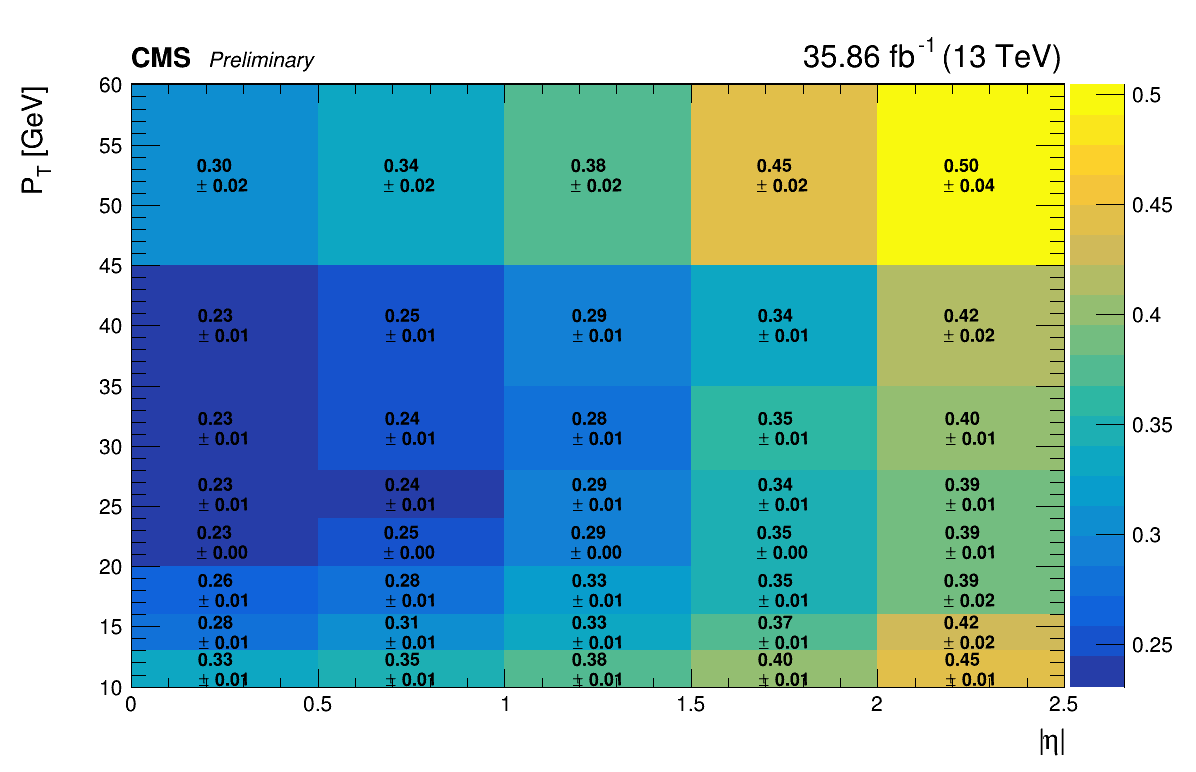

In [15]:
fake_rate_m = h_nume_m.Clone("fake_rate_m")
fake_rate_m.Divide(h_deno_m)

fake_rate_m.SetDirectory(0)
c1 = ROOT.TCanvas("","",1200,800)
fake_rate_m.SetStats(0)
fake_rate_m.SetXTitle("|#eta|")
fake_rate_m.SetYTitle("P_{T} [GeV]")
fake_rate_m.SetMarkerSize(1.3)
ROOT.gStyle.SetPaintTextFormat('4.2f')
fake_rate_m.Draw("COLZe TEXT")
c1.Draw()
CMS_lumi(c1,0,0)
# c1.SaveAs('Fake_Lepton/2017/FR_Electron_data_2017_new.pdf')
# c1.SaveAs('Fake_Lepton/2017/FR_Electron_data_2017_new.png')

file1 = ROOT.TFile("mu.root","recreate")
file1.cd()
fake_rate_m.Write()
file1.Close()